# Higher-order (HO) approximation on dome-shaped ice sheet

This script applies the Blatter-Pattyn approximation to a dome-shaped ice sheet, comparing results to the analytic SIA solution for validation. We use helper functions from ```issm_helper```.

## Imports

In [1]:
########################
### "normal" imports ###
########################

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

######################
### ISSM functions ###
######################

from model import model
from squaremesh import squaremesh
from bamg import bamg

from issm_helper import *

## Initialize model and mesh domain

We will mesh the domain as a square, then later define the ice sheet to have a circular footprint within that square. 

In [2]:
len_x, len_y = 100e3, 100e3
nx, ny = 50, 50
Δx, Δy = int(len_x/nx), int(len_y/ny)

md = model()
md = squaremesh(md, len_x, len_y, nx, ny) 

## Define circular footprint and refine mesh

Refine so that we have higher mesh density near the periphery of the ice sheet, then apply ice and ocean levelsets.  

In [3]:
#####################
### circle params ###
#####################

x, y = md.mesh.x, md.mesh.y
x_0, y_0 = np.mean(x), np.mean(y) #the centre of the mesh is at (x_0, y_0)
r = min(x_0, y_0)   #ensure the circular footprint stays within the meshed area
d = np.sqrt((x - x_0)**2 + (y - y_0)**2)

#######################
### refine the mesh ###
#######################

length_scale = x.max()/100
size_min, size_max = min(Δx, Δy)/10, max(Δx, Δy)
refinement_function = np.exp(-((r - d)/length_scale)**2)
md = bamg(md, 'field', refinement_function, 'err', 5e-3, 'hmin', size_min, 'hmax', size_max)

##########################################
### reinitialize mesh-dependent params ###
##########################################

x, y = md.mesh.x, md.mesh.y
elts = md.mesh.elements - 1
d = np.sqrt((x - x_0)**2 + (y - y_0)**2)

############################
### initialize levelsets ###
############################

md.mask.ice_levelset = d**2 - r**2 #negative within the footprint, positive outside, zero at circular boundary
md.mask.ocean_levelset = np.ones_like(x)   #pos = grounded, neg = floating, 0 = GL

############################
### dirichlet boundaries ###
############################

centerpoint = np.argmin(d)         
Γ_inflow = (np.arange(x.size) == centerpoint) #constrain thickness at the centerpoint of the ice sheet
Γ_x = Γ_inflow.copy() #velocity at center will be constrained to zero
Γ_y = Γ_inflow.copy() #in both directions

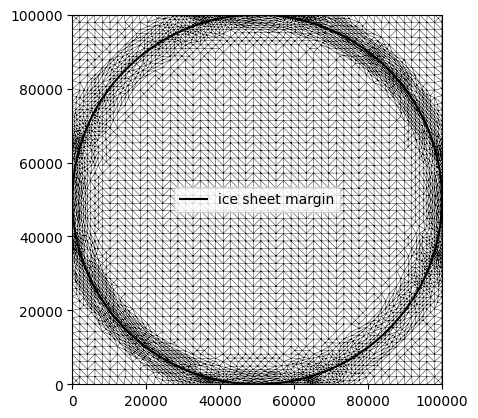

In [4]:
plt.triplot(x, y, elts, linewidth = 0.3, color = 'k')
plt.tricontour(x, y, elts, md.mask.ice_levelset, levels = [0], colors = 'k')
plt.plot([], [], 'k', label = 'ice sheet margin')   # dummy legend handle
plt.legend()
plt.gca().set_aspect('equal')

## Set initial thickness

In [5]:
############################
### geometric parameters ###
############################

H_max = 1000
H = H_max/r*np.sqrt(np.maximum(0, r**2 - d**2))
H += 1 #keep zeros out
s = H.copy()
H_0 = H.copy()

##############
### solver ###
##############

md = setflowequation(md, 'HO', 'all') #apply the HO approximation over the entire domain

## Initialize the model and solve

In [6]:
initialize_model(md, approximation = 'HO', friction = 1000, 
                 dirichlet_H = Γ_inflow, dirichlet_x = Γ_x, dirichlet_y = Γ_y)

      no smb.mass_balance specified: values set as zero


In [7]:
u = diagnostic_solve(md, thickness = H, surface = s, friction = 1000, velocity = (0, 0))

Δt = 1
H, s = prognostic_solve(md, Δt, velocity = u, thickness = H, surface = s, thickness_inflow = H_0) 

## Plot results

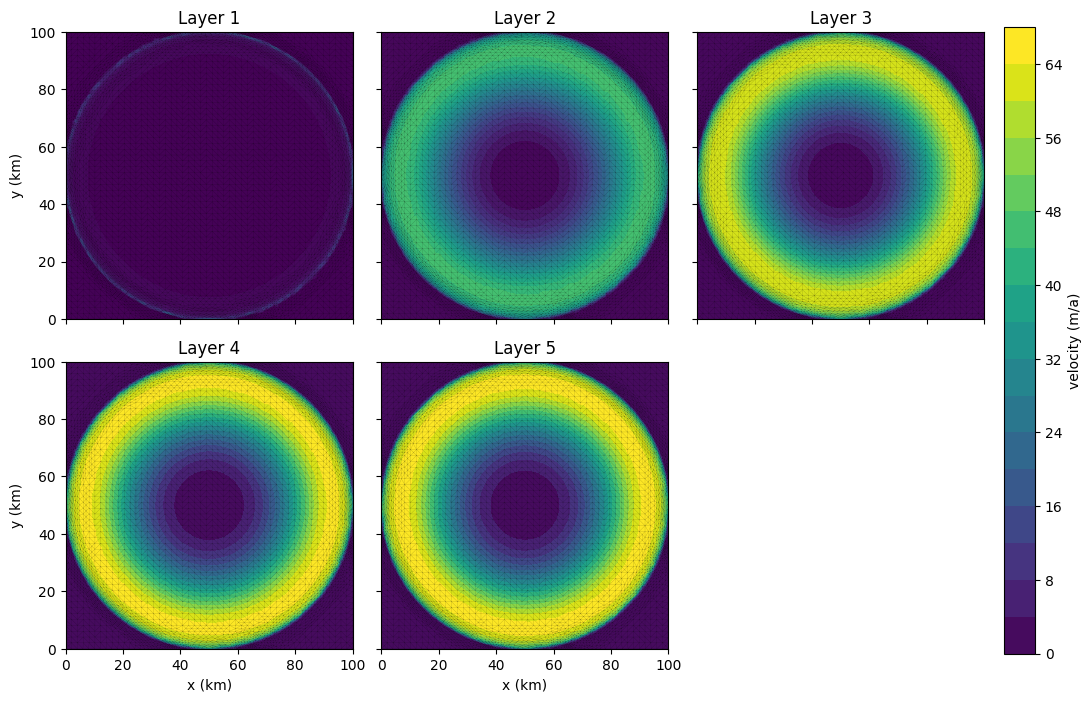

In [8]:
num_layers = md.mesh.numberoflayers
num_nodes_surface = md.mesh.numberofvertices2d
triangles_surface = md.mesh.elements2d - 1
speed3d = np.hypot(u[0], u[1])

cols = int(np.ceil(num_layers**0.5))
rows = int(np.ceil(num_layers/cols))

fig, axes = plt.subplots(rows, cols, figsize = (4*cols, 4*rows), sharex = 'col', sharey = 'row',
                         gridspec_kw = {'wspace': 0.1, 'hspace': -0.1})
axes = np.atleast_1d(axes).ravel()

km = FuncFormatter(lambda v, _: f'{v/1000:.0f}')
vmax = speed3d.max()

for layer, ax in enumerate(axes):
    if layer >= num_layers: ax.axis('off'); continue
    node_slice = slice(layer*num_nodes_surface, (layer + 1)*num_nodes_surface)

    contour = ax.tricontourf(md.mesh.x[node_slice], md.mesh.y[node_slice], triangles_surface, speed3d[node_slice],
                             levels = 20, vmin = 0, vmax = vmax)

    ax.triplot(md.mesh.x[node_slice], md.mesh.y[node_slice], triangles_surface, color = 'k', linewidth = 0.15, alpha = 0.4)

    ax.set(title = f'Layer {layer + 1}', aspect = 'equal')
    ax.xaxis.set_major_formatter(km); ax.yaxis.set_major_formatter(km)

for ax in axes[-cols:]: ax.set_xlabel('x (km)')
for ax in axes[::cols]: ax.set_ylabel('y (km)')

fig.subplots_adjust(left = 0.07, right = 0.88, bottom = 0.08, top = 0.95)
fig.colorbar(contour, ax = axes[:num_layers], fraction = 0.035, pad = 0.02, shrink = 0.9).set_label('velocity (m/a)')

plt.show()


## Compare numerical HO results with semi-analytic SIA solution

In [9]:
H_nonzero = H_0.copy()
H_nonzero[H_nonzero <= 0] = np.nan
thick_grad = (H_max/r)**2*d/H_nonzero #analytic thickness gradient 
n = md.materials.rheology_n
u_SIA = (2*md.miscellaneous.rheology_A/(n + 1))*(917*9.81*thick_grad)**n*H_nonzero**(n + 1) #analytic surface velocity
u_SIA *= 60*60*24*365.25 #into m/a
u_SIA[np.isnan(u_SIA)] = 0. #eliminate nans

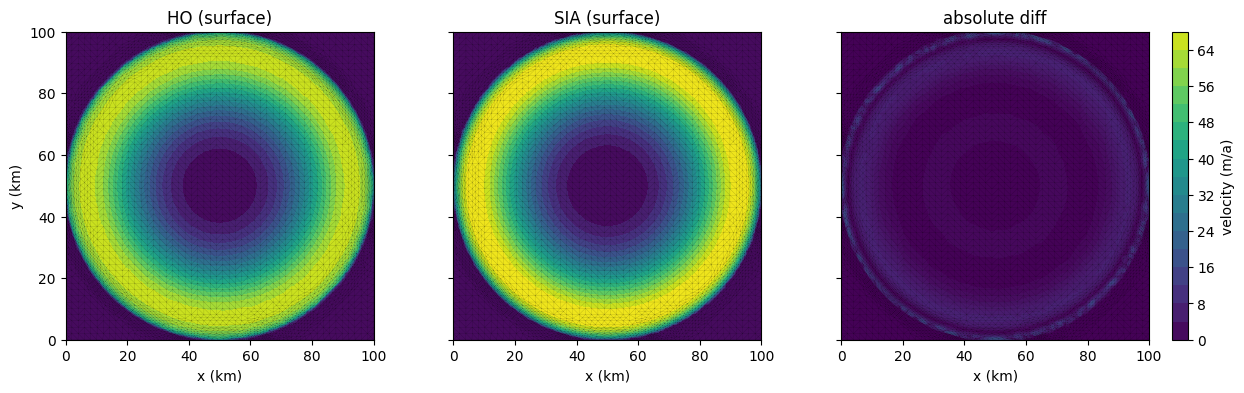

In [10]:
from matplotlib.ticker import FuncFormatter

top = slice((num_layers - 1)*num_nodes_surface, num_layers*num_nodes_surface)
u_HO_top = speed3d[top]
u_diff = np.abs(u_HO_top - u_SIA)

vmax = max(u_HO_top.max(), u_SIA.max(), u_diff.max())

km = FuncFormatter(lambda v, _: f'{v/1000:.0f}')

x2 = getattr(md.mesh, 'x2d', md.mesh.x[:num_nodes_surface])
y2 = getattr(md.mesh, 'y2d', md.mesh.y[:num_nodes_surface])

fig, ax = plt.subplots(1, 3, figsize = (15, 4), sharex = True, sharey = True)

p0 = ax[0].tricontourf(x2, y2, triangles_surface, u_HO_top, levels = 20, vmin = 0, vmax = vmax)
p1 = ax[1].tricontourf(x2, y2, triangles_surface, u_SIA,   levels = 20, vmin = 0, vmax = vmax)
p2 = ax[2].tricontourf(x2, y2, triangles_surface, u_diff,  levels = 20, vmin = 0, vmax = vmax)

for a in ax:
    a.triplot(x2, y2, triangles_surface, color = 'k', linewidth = 0.15, alpha = 0.4)
    a.set(aspect = 'equal')
    a.xaxis.set_major_formatter(km)
    a.yaxis.set_major_formatter(km)

ax[0].set(title = 'HO (surface)', xlabel = 'x (km)', ylabel = 'y (km)')
ax[1].set(title = 'SIA (surface)', xlabel = 'x (km)')
ax[2].set(title = 'absolute diff', xlabel = 'x (km)')

fig.colorbar(p0, ax = ax, fraction = 0.035, pad = 0.02).set_label('velocity (m/a)')

plt.show()

## Plot thickness change 

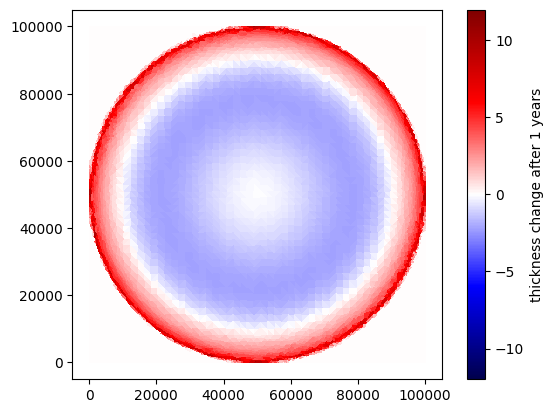

In [11]:
ΔH = H - H_0
vmax = np.max(np.abs(ΔH))
plt.figure()
plt.tripcolor(x, y, elts, ΔH, vmin = -vmax, vmax = vmax, cmap = 'seismic')
plt.colorbar().set_label(f'thickness change after {Δt} years')
plt.gca().set_aspect('equal')